# **Lab Assignment Seven: Sequential Network Architectures**

### By William Cooper (undergraduate) and Grant Palmer (Undergraduate)

### Data Set: SMS Spam Collection Dataset
Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

# Preparation

*Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.*

The SMS Spam Collection Dataset contains the following Columns:
1.   v1: This column is used to denote whether the SMS message is spam or ham, which basically means the message is spam or is not spam.
2.   v2: This column is used to store the SMS message itself in the form of text.



In [ ]:
#loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/Colab Notebooks/spam.csv'

df = pd.read_csv(file_path, encoding = 'latin1')

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


The other three columns that are not v1 or v2, are unnamed and will not be useful for the training of our data. Because of this we decided to remove them to ensure that our data is clean and that our prediction task is efficient.

In [ ]:
df = {
    'sms' : df['v2'][:].values.tolist(), 'spam_status' : df['v1'].values.tolist()
}
df = pd.DataFrame(df)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sms          5572 non-null   object
 1   spam_status  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,sms,spam_status
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
5,FreeMsg Hey there darling it's been 3 week's n...,spam
6,Even my brother is not like to speak with me. ...,ham
7,As per your request 'Melle Melle (Oru Minnamin...,ham
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam


We decided that an SMS message with a large length size would take time to train, and is likely going to cause future problems down the road, so we decided to find the max length of any SMS message in the dataset.

In [ ]:
sms_len = [len(sms) for sms in df['sms']]
print(f'Max SMS size: {max(sms_len)}')

Max SMS size: 910


910 words is a very long SMS message, and is something that we likely do not want to include in our dataset. However, most SMS messages might be around this length so we decied to find the average length amongst the SMS messages.

In [ ]:
sms_len = [len(sms) for sms in df['sms']]
average_sms_length = np.mean(sms_len)

print(f'Average SMS size: {average_sms_length:.2f}')

Average SMS size: 80.12


With an average SMS size at 80, the Max SMS value of 910 is way too high for us to include in our dataset. We decided to plot this data, and determine just how many outliers there are through a violin plot.

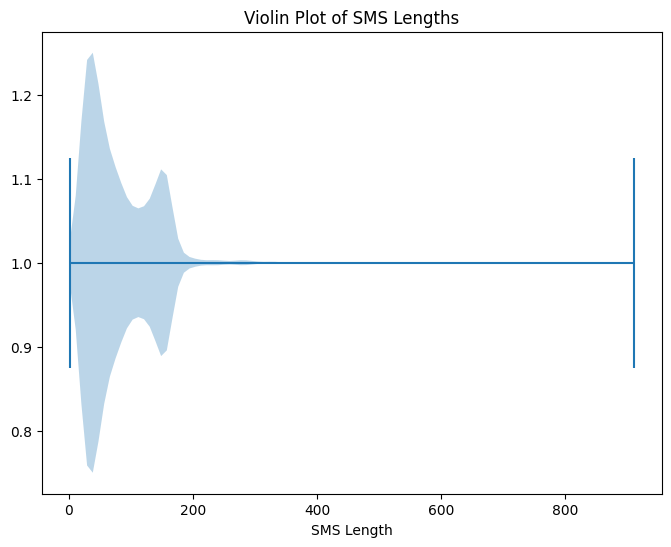

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.violinplot(sms_len, vert=False)
plt.xlabel('SMS Length')
plt.title('Violin Plot of SMS Lengths')
plt.show()

It would appear that not many of the SMS messages within our dataset exceed 200-300 words, so we have decided to remove all SMS messages that exceed 300 words.

In [ ]:
# Filter out SMS messages that exceed 300 characters
df = df[df['sms'].str.len() <= 300]

# Optionally, reset the index if needed
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5537 entries, 0 to 5536
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sms          5537 non-null   object
 1   spam_status  5537 non-null   object
dtypes: object(2)
memory usage: 86.6+ KB


Now that we have removed the long SMS messages, we need to see if the dataset is imbalanced between messages that are spam and not spam.

In [ ]:
df['spam_status'].value_counts()

spam_status
ham     4790
spam     747
Name: count, dtype: int64

There is clearly an imbalance between how many messages are considered to be spam, and how many messages are not spam. Because of this we will definetly need to stratify the dataset to get a more equal distribution of the data.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['spam_status'])

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 300 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['sms'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df['sms'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = keras.utils.to_categorical(y_encoded)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Found 8741 unique tokens. Distilled to 8741 top words.
Shape of data tensor: (5537, 300)
Shape of label tensor: (5537, 2)
8741


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=y_encoded,
                                                            random_state=42)

*Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*

The metric that we will be using to evaluate our algorithm's performance is through Area Under the Curve. Because our data is imbalanced, AUC would do a great job at evaulating all of the data, and not just looking at the majority (non-spam messages). AUC would also be a great way to evaluate our algorithms performance because it focuses on true positives and true negatives. In terms of real world application, this would be crucial as spam messages are usually a way for hackers to breach user privacy, and helps the user know whether the message they are recieving is one that is spam or not spam.

Source: https://keras.io/api/metrics/classification_metrics/#auc-class

*Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.*

The method that we have chosen for dividing our data into training and testing is through a Stratified Train Test Split. A Stratified Train Test Split would be appropriate in this case because it does a good job with uneven class distribution. In our case, there are a lot more non-spam messages than there are spam messages, so the Stratification of the data would do a good job at evening out class distribution. In the real world, stratification of the data would be crucial to training and testing because it ensures that our algorithm is evaluated by both spam and non-spam messages, which would further ensure a better generalization of the data.

# Modeling

*Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.*

In [ ]:
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (8742, 50) 
 Total words found: 6389 
 Percentage: 73.0839624799817


In [ ]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.metrics import AUC

NUM_CLASSES = 2

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 300
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 300-4=296
x = MaxPooling1D(5)(x) # after max pool, 296/5 = 59
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 55
x = MaxPooling1D(5)(x) # after max pool, size is 55/5 = 11
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 7 elements long
x = MaxPooling1D(7)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 7 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[AUC()])

print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 300, 50)           437100    
                                                                 
 conv1d_27 (Conv1D)          (None, 296, 128)          32128     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 59, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 59, 128)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 55, 128)           82048     
                                                           

In [ ]:
histories = []
tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories.append(tmp)

Epoch 1/2
9/9 [==============================] - 11s 1s/step - loss: 0.4859 - auc_3: 0.8737 - val_loss: 0.2879 - val_auc_3: 0.9517
Epoch 2/2
9/9 [==============================] - 8s 859ms/step - loss: 0.2794 - auc_3: 0.9515 - val_loss: 0.2198 - val_auc_3: 0.9730


In [ ]:
histories = []
tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=10, batch_size=512)
histories.append(tmp)

Epoch 1/10
9/9 [==============================] - 10s 1s/step - loss: 0.1933 - auc_3: 0.9752 - val_loss: 0.2327 - val_auc_3: 0.9596
Epoch 2/10
9/9 [==============================] - 8s 867ms/step - loss: 0.1879 - auc_3: 0.9737 - val_loss: 0.1654 - val_auc_3: 0.9742
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.1510 - auc_3: 0.9820 - val_loss: 0.1510 - val_auc_3: 0.9817
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.1482 - auc_3: 0.9822 - val_loss: 0.1271 - val_auc_3: 0.9814
Epoch 5/10
9/9 [==============================] - 8s 870ms/step - loss: 0.1048 - auc_3: 0.9886 - val_loss: 0.1378 - val_auc_3: 0.9852
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.1423 - auc_3: 0.9819 - val_loss: 0.1111 - val_auc_3: 0.9865
Epoch 7/10
9/9 [==============================] - 9s 997ms/step - loss: 0.0920 - auc_3: 0.9891 - val_loss: 0.1714 - val_auc_3: 0.9758
Epoch 8/10
9/9 [==============================] - 8s 868ms/step - loss: 0

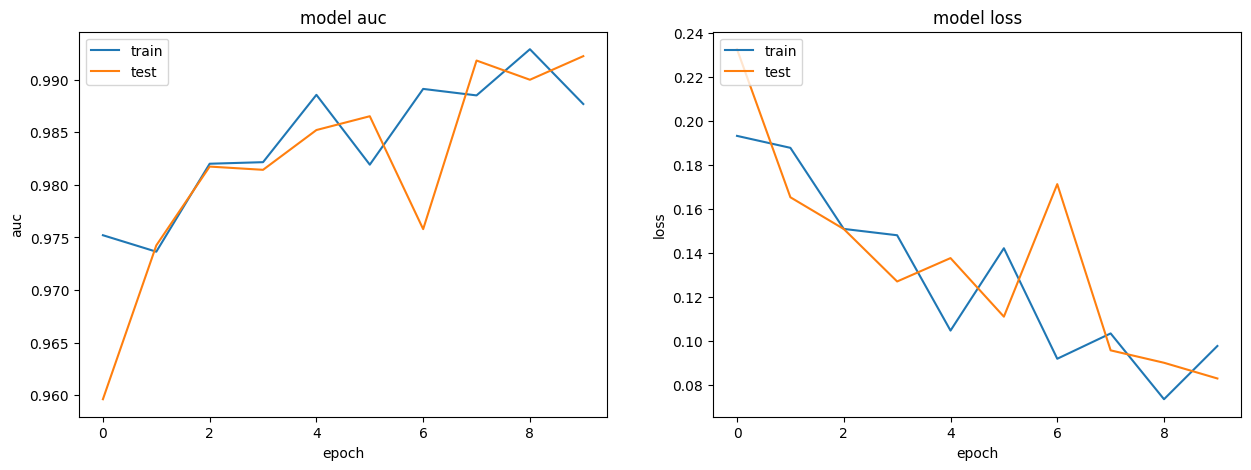

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_3','val_auc_3','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_3'])
plt.plot(combined['val_auc_3'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model.predict(X_test)  # sigmoid output probabilities
yhat1 = np.round(yhat_proba.squeeze())  # round to get binary class

evals1 = roc_auc_score(y_test, yhat_proba)  # compute AUC score
print("AUC Score:", evals1)

35/35 [==============================] - 1s 19ms/step
AUC Score: 0.9848223471037365


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.metrics import AUC

NUM_CLASSES = 2

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 300
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 300-4=296
x = MaxPooling1D(5)(x) # after max pool, 296/5 = 59
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 55
x = MaxPooling1D(5)(x) # after max pool, size is 55/5 = 11
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 7 elements long
x = MaxPooling1D(7)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 7 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[AUC()])

print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 300, 50)           437100    
                                                                 
 conv1d_27 (Conv1D)          (None, 296, 128)          32128     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 59, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 59, 128)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 55, 128)           82048     
                                                           

In [ ]:
histories2 = []
tmp = model2.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories2.append(tmp)

Epoch 1/2
9/9 [==============================] - 9s 899ms/step - loss: 0.4370 - auc_4: 0.8900 - val_loss: 0.2651 - val_auc_4: 0.9569
Epoch 2/2
9/9 [==============================] - 9s 1s/step - loss: 0.2515 - auc_4: 0.9584 - val_loss: 0.2341 - val_auc_4: 0.9623


In [ ]:
tmp = model2.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=10, batch_size=512)
histories2.append(tmp)

Epoch 1/10
9/9 [==============================] - 10s 1s/step - loss: 0.1971 - auc_4: 0.9719 - val_loss: 0.1760 - val_auc_4: 0.9717
Epoch 2/10
9/9 [==============================] - 8s 949ms/step - loss: 0.1452 - auc_4: 0.9834 - val_loss: 0.1449 - val_auc_4: 0.9787
Epoch 3/10
9/9 [==============================] - 9s 900ms/step - loss: 0.1141 - auc_4: 0.9861 - val_loss: 0.1318 - val_auc_4: 0.9842
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.1042 - auc_4: 0.9869 - val_loss: 0.1093 - val_auc_4: 0.9894
Epoch 5/10
9/9 [==============================] - 14s 2s/step - loss: 0.0922 - auc_4: 0.9902 - val_loss: 0.0965 - val_auc_4: 0.9924
Epoch 6/10
9/9 [==============================] - 8s 869ms/step - loss: 0.0865 - auc_4: 0.9909 - val_loss: 0.0798 - val_auc_4: 0.9932
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.0678 - auc_4: 0.9931 - val_loss: 0.0701 - val_auc_4: 0.9923
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.0

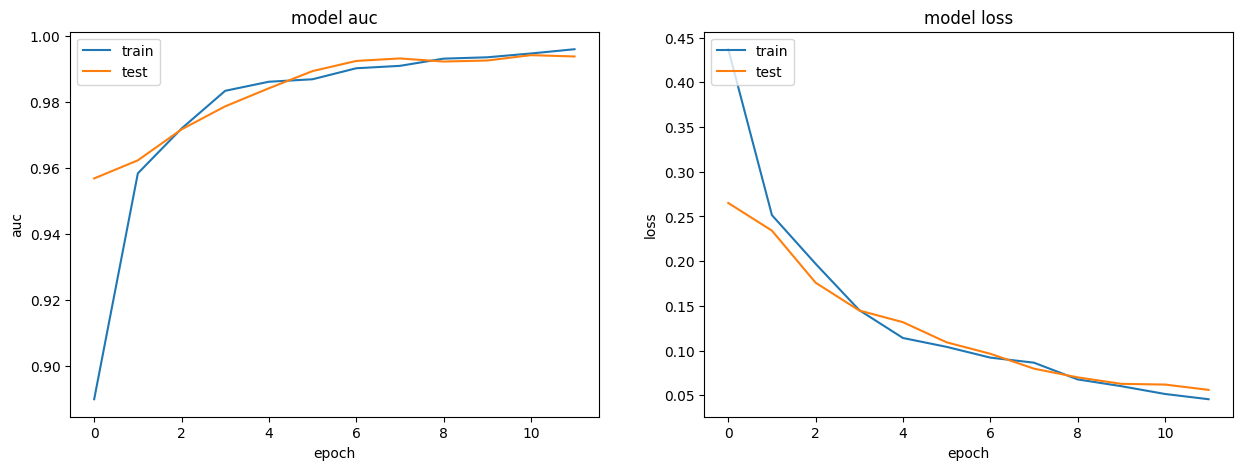

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_4','val_auc_4','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories2])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_4'])
plt.plot(combined['val_auc_4'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model.predict(X_test)  # sigmoid output probabilities
yhat2 = np.round(yhat_proba.squeeze())  # round to get binary class

evals2 = roc_auc_score(y_test, yhat2)  # compute AUC score
print("AUC Score:", evals2)

35/35 [==============================] - 2s 49ms/step
AUC Score: 0.9322980453632489


In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)

        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf

# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [ ]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer20 = Model(inputs=inputs, outputs=preds)
print(model_xformer20.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 300)]             0         
                                                                 
 glove_token_and_position_e  (None, 300, 50)           452100    
 mbedding (GloveTokenAndPos                                      
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfo  (None, 300, 50)           44132     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_34 (Dropout)        (None, 50)                0  

In [ ]:
from keras.metrics import AUC

model_xformer20.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[AUC()])
histories3 = []
tmp = model_xformer20.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories3.append(tmp)

Epoch 1/2
9/9 [==============================] - 109s 12s/step - loss: 0.3707 - auc_5: 0.9120 - val_loss: 0.2263 - val_auc_5: 0.9745
Epoch 2/2
9/9 [==============================] - 92s 10s/step - loss: 0.2431 - auc_5: 0.9631 - val_loss: 0.1907 - val_auc_5: 0.9821


In [ ]:
tmp = model_xformer20.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories3.append(tmp)

Epoch 1/10
9/9 [==============================] - 108s 12s/step - loss: 0.1889 - auc_5: 0.9750 - val_loss: 0.1440 - val_auc_5: 0.9811
Epoch 2/10
9/9 [==============================] - 93s 11s/step - loss: 0.1637 - auc_5: 0.9781 - val_loss: 0.1334 - val_auc_5: 0.9840
Epoch 3/10
9/9 [==============================] - 95s 11s/step - loss: 0.1393 - auc_5: 0.9837 - val_loss: 0.1262 - val_auc_5: 0.9843
Epoch 4/10
9/9 [==============================] - 93s 10s/step - loss: 0.1489 - auc_5: 0.9795 - val_loss: 0.1216 - val_auc_5: 0.9863
Epoch 5/10
9/9 [==============================] - 93s 10s/step - loss: 0.1345 - auc_5: 0.9834 - val_loss: 0.1557 - val_auc_5: 0.9830
Epoch 6/10
9/9 [==============================] - 92s 10s/step - loss: 0.1156 - auc_5: 0.9880 - val_loss: 0.1162 - val_auc_5: 0.9878
Epoch 7/10
9/9 [==============================] - 91s 10s/step - loss: 0.1323 - auc_5: 0.9836 - val_loss: 0.1147 - val_auc_5: 0.9883
Epoch 8/10
9/9 [==============================] - 94s 11s/step - los

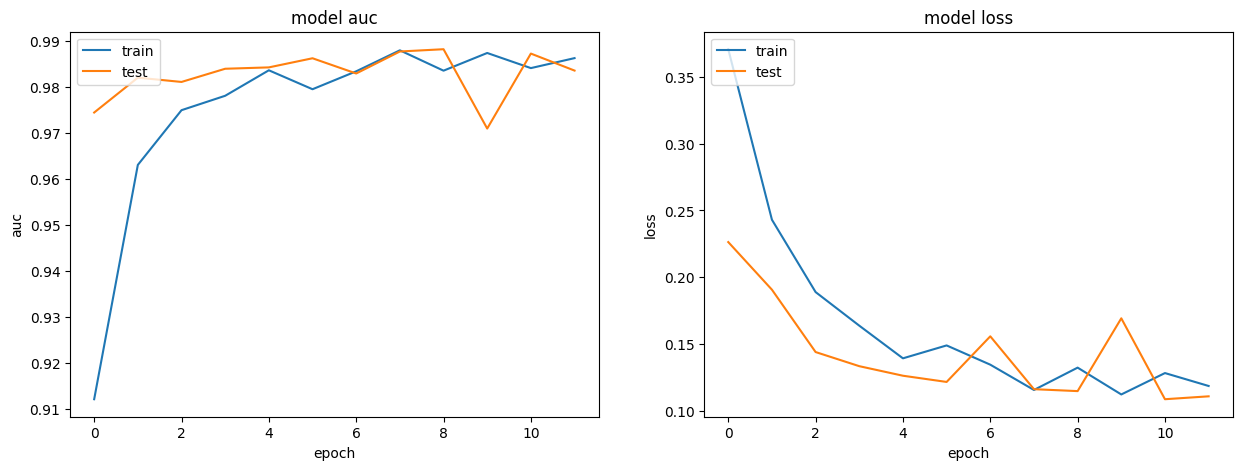

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_5','val_auc_5','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories3])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_5'])
plt.plot(combined['val_auc_5'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model_xformer20.predict(X_test)  # sigmoid output probabilities
yhat3 = np.round(yhat_proba.squeeze())  # round to get binary class

evals3 = roc_auc_score(y_test, yhat3)  # compute AUC score
print("AUC Score:", evals3)

35/35 [==============================] - 7s 198ms/step
AUC Score: 0.9237285763274103


In [ ]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer21 = Model(inputs=inputs, outputs=preds)
print(model_xformer21.summary())

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 300)]             0         
                                                                 
 glove_token_and_position_e  (None, 300, 50)           452100    
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 300, 50)           44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_38 (Dropout)        (None, 50)                0  

In [ ]:
from keras.metrics import AUC

model_xformer21.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[AUC()])
histories4 = []
tmp = model_xformer21.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories4.append(tmp)

Epoch 1/2
9/9 [==============================] - 106s 11s/step - loss: 0.4708 - auc_6: 0.8583 - val_loss: 0.3928 - val_auc_6: 0.9270
Epoch 2/2
9/9 [==============================] - 89s 10s/step - loss: 0.3867 - auc_6: 0.8983 - val_loss: 0.3303 - val_auc_6: 0.9656


In [ ]:
tmp = model_xformer21.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories4.append(tmp)

Epoch 1/10
9/9 [==============================] - 92s 10s/step - loss: 0.3039 - auc_6: 0.9539 - val_loss: 0.2185 - val_auc_6: 0.9784
Epoch 2/10
9/9 [==============================] - 90s 10s/step - loss: 0.1938 - auc_6: 0.9792 - val_loss: 0.1505 - val_auc_6: 0.9803
Epoch 3/10
9/9 [==============================] - 94s 11s/step - loss: 0.1446 - auc_6: 0.9825 - val_loss: 0.1361 - val_auc_6: 0.9766
Epoch 4/10
9/9 [==============================] - 92s 10s/step - loss: 0.1268 - auc_6: 0.9835 - val_loss: 0.1204 - val_auc_6: 0.9850
Epoch 5/10
9/9 [==============================] - 91s 10s/step - loss: 0.1194 - auc_6: 0.9866 - val_loss: 0.1111 - val_auc_6: 0.9887
Epoch 6/10
9/9 [==============================] - 94s 10s/step - loss: 0.1074 - auc_6: 0.9899 - val_loss: 0.1053 - val_auc_6: 0.9872
Epoch 7/10
9/9 [==============================] - 90s 10s/step - loss: 0.1017 - auc_6: 0.9882 - val_loss: 0.1093 - val_auc_6: 0.9859
Epoch 8/10
9/9 [==============================] - 109s 12s/step - los

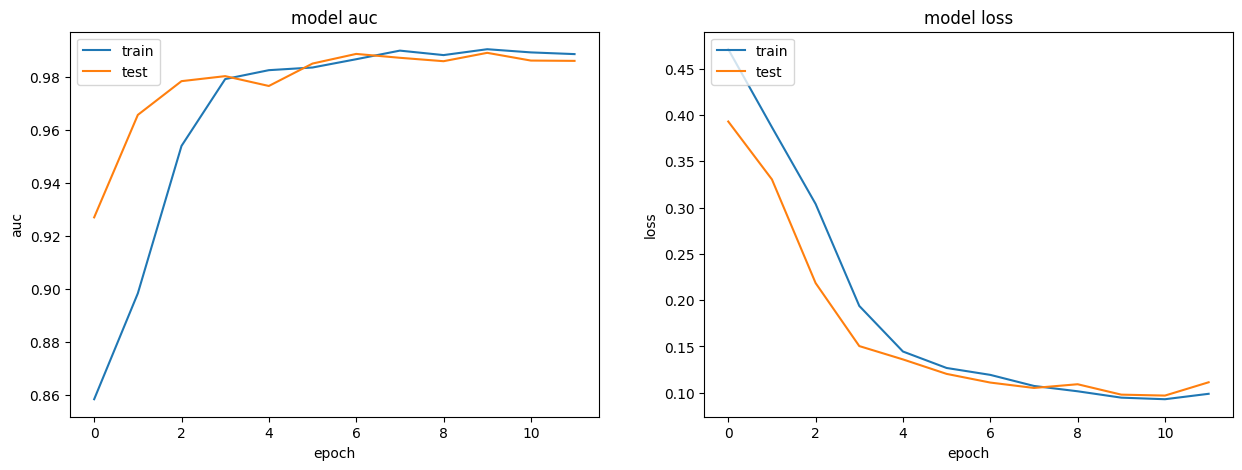

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_6','val_auc_6','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories4])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_6'])
plt.plot(combined['val_auc_6'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model_xformer21.predict(X_test)  # sigmoid output probabilities
yhat4 = np.round(yhat_proba.squeeze())  # round to get binary class

evals4 = roc_auc_score(y_test, yhat4)  # compute AUC score
print("AUC Score:", evals4)

35/35 [==============================] - 9s 245ms/step
AUC Score: 0.8907593900245642


*Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged..*

In [ ]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xformer21 = Model(inputs=inputs, outputs=preds)
print(model_xformer21.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 300)]             0         
                                                                 
 glove_token_and_position_e  (None, 300, 50)           452100    
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 300, 50)           44132     
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 300, 50)           44132     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 50)                0  

In [ ]:
from keras.metrics import AUC

model_xformer21.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[AUC()])
histories5 = []
tmp = model_xformer21.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=2, batch_size=512)
histories5.append(tmp)

Epoch 1/2
9/9 [==============================] - 208s 22s/step - loss: 0.4649 - auc_7: 0.8639 - val_loss: 0.4160 - val_auc_7: 0.9415
Epoch 2/2
9/9 [==============================] - 185s 21s/step - loss: 0.3939 - auc_7: 0.8893 - val_loss: 0.3524 - val_auc_7: 0.9651


In [ ]:
tmp = model_xformer21.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=10, batch_size=512)
histories5.append(tmp)

Epoch 1/10
9/9 [==============================] - 184s 21s/step - loss: 0.3223 - auc_7: 0.9458 - val_loss: 0.1971 - val_auc_7: 0.9747
Epoch 2/10
9/9 [==============================] - 184s 21s/step - loss: 0.1897 - auc_7: 0.9770 - val_loss: 0.1682 - val_auc_7: 0.9749
Epoch 3/10
9/9 [==============================] - 181s 20s/step - loss: 0.1438 - auc_7: 0.9811 - val_loss: 0.1640 - val_auc_7: 0.9738
Epoch 4/10
9/9 [==============================] - 181s 20s/step - loss: 0.1347 - auc_7: 0.9833 - val_loss: 0.1346 - val_auc_7: 0.9764
Epoch 5/10
9/9 [==============================] - 182s 20s/step - loss: 0.1166 - auc_7: 0.9870 - val_loss: 0.1180 - val_auc_7: 0.9866
Epoch 6/10
9/9 [==============================] - 183s 20s/step - loss: 0.1098 - auc_7: 0.9896 - val_loss: 0.1074 - val_auc_7: 0.9841
Epoch 7/10
9/9 [==============================] - 187s 21s/step - loss: 0.1024 - auc_7: 0.9898 - val_loss: 0.1064 - val_auc_7: 0.9822
Epoch 8/10
9/9 [==============================] - 243s 27s/ste

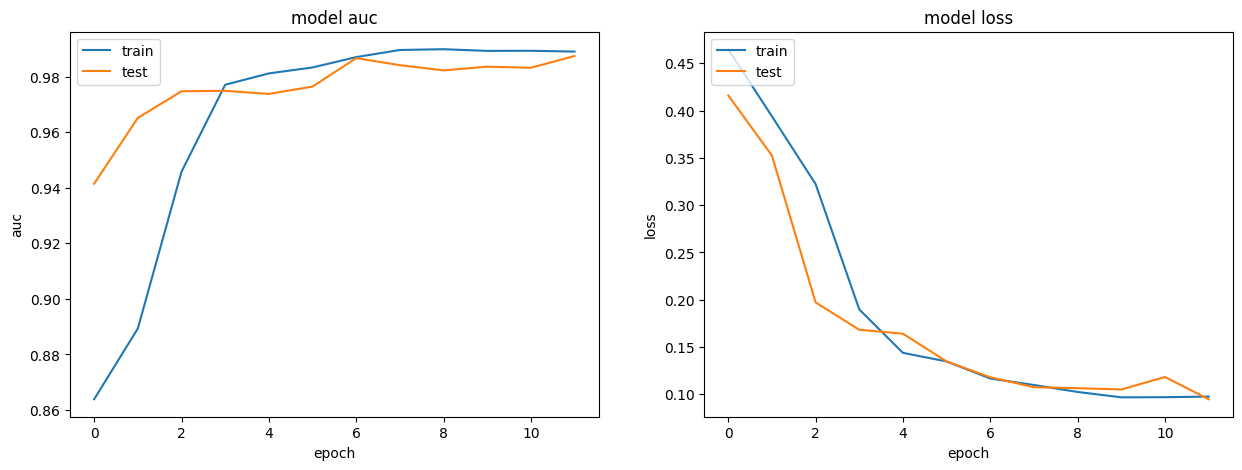

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_7','val_auc_7','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories5])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_7'])
plt.plot(combined['val_auc_7'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model_xformer21.predict(X_test)  # sigmoid output probabilities
yhat5 = np.round(yhat_proba.squeeze())  # round to get binary class

evals5 = roc_auc_score(y_test, yhat5)  # compute AUC score
print("AUC Score:", evals5)

35/35 [==============================] - 16s 453ms/step
AUC Score: 0.913727946476685


*Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.*

Throughout the performance of each model, we created an AUC Score, and stored the score in variables evals1, evals2, and so on. We then decided that the comparison of these scores should give us a good and accurate idea of which model gives us the greatest AUC Score, and therefore the most superior method. Our findings are as follows:

In [ ]:
print('AUC Score 1, CNN (RMSProp):', evals1)
print('AUC Score for Model 2, CNN (AdaM):', evals2)
print('AUC Score for Model 3, Transformer (RMSProp):', evals3)
print('AUC Score for Model 4, Transformer (AdaM):', evals4)
print('AUC Score for Model 5, Transformer (Second Multi-headed Self Attention Layer):', evals5)

AUC Score 1, CNN (RMSProp): 0.9848223471037365
AUC Score for Model 2, CNN (AdaM): 0.9322980453632489
AUC Score for Model 3, Transformer (RMSProp): 0.9237285763274103
AUC Score for Model 4, Transformer (AdaM): 0.8907593900245642
AUC Score for Model 5, Transformer (Second Multi-headed Self Attention Layer): 0.913727946476685


Surprisingly, amongst the 5 different methods we used to evaluate our algorithm, the first evaluation yielded the highest AUC Score of 98.48%. The second highest AUC Score was in our second evaluation, yielding an AUC Score of 93.23%. These results statistically show us that the CNN preformed better than the Transformer did on all levels. Further, the CNN that used RMSProp had the highest AUC Score. Therefor, the methods that are most superior are those that use a Convolutional Neural Network, and specifically those that use RMSProp as the optimizer.

*Exceptional Work*

Since the most accurate AUC Score was when using a Convoluted Neural Network with the RMSProp optimizer, we decided to do extra analyses to determine if we could get an even greater AUC Score by using a different optimizer. We decided that we will still use a CNN, but for our optimizer we are going to use Adagrad. The reason that we are choosing Adagrad is because its learning rate changes for each parameter, and because it should result in fewer losses over more iterations.

Source: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

NUM_CLASSES = 2

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 300
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 300-4=296
x = MaxPooling1D(5)(x) # after max pool, 296/5 = 59
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 55
x = MaxPooling1D(5)(x) # after max pool, size is 55/5 = 11
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 7 elements long
x = MaxPooling1D(7)(x) # this is the size to globally flatten
# flattened vector max pools across each of the 7 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model3 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model3.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=[AUC()])

print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 300, 50)           437100    
                                                                 
 conv1d_27 (Conv1D)          (None, 296, 128)          32128     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 59, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 59, 128)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 55, 128)           82048     
                                                           

In [ ]:
histories6 = []
tmp = model3.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=2, batch_size=512)
histories6.append(tmp)

Epoch 1/2
9/9 [==============================] - 11s 1s/step - loss: 0.5875 - auc_9: 0.8388 - val_loss: 0.5371 - val_auc_9: 0.8629
Epoch 2/2
9/9 [==============================] - 8s 857ms/step - loss: 0.5529 - auc_9: 0.8359 - val_loss: 0.5120 - val_auc_9: 0.8483


In [ ]:
histories6 = []
tmp = model3.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=10, batch_size=512)
histories6.append(tmp)

Epoch 1/10
9/9 [==============================] - 15s 2s/step - loss: 0.5091 - auc_9: 0.8259 - val_loss: 0.4721 - val_auc_9: 0.8456
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.4988 - auc_9: 0.8306 - val_loss: 0.4633 - val_auc_9: 0.8515
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.4871 - auc_9: 0.8347 - val_loss: 0.4554 - val_auc_9: 0.8586
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 0.4772 - auc_9: 0.8423 - val_loss: 0.4479 - val_auc_9: 0.8668
Epoch 5/10
9/9 [==============================] - 19s 2s/step - loss: 0.4730 - auc_9: 0.8439 - val_loss: 0.4409 - val_auc_9: 0.8741
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.4660 - auc_9: 0.8482 - val_loss: 0.4341 - val_auc_9: 0.8811
Epoch 7/10
9/9 [==============================] - 8s 865ms/step - loss: 0.4633 - auc_9: 0.8481 - val_loss: 0.4277 - val_auc_9: 0.8894
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.4507

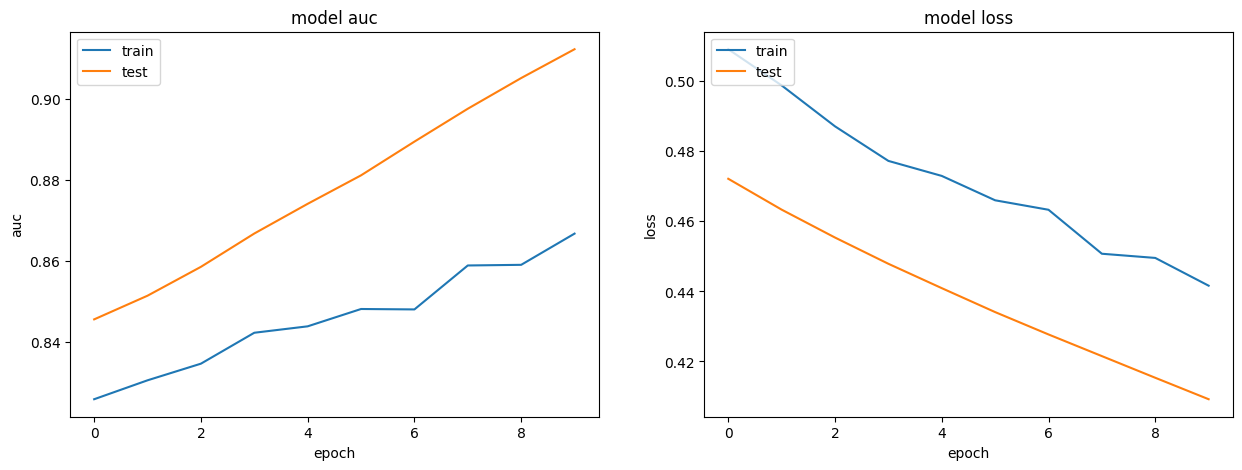

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['auc_9','val_auc_9','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories6])

# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['auc_9'])
plt.plot(combined['val_auc_9'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# now let's see how well the model performed
yhat_proba = model3.predict(X_test)  # sigmoid output probabilities
yhat6 = np.round(yhat_proba.squeeze())  # round to get binary class

evals6 = roc_auc_score(y_test, yhat6)  # compute AUC score
print("AUC Score:", evals6)

35/35 [==============================] - 1s 18ms/step
AUC Score: 0.5


Unfortunately using Adagrad did not improve any results from what we had previously seen when using optimizers like Adam or RMSProp. Having an AUC Score of 50% is not ideal, especially considering that our previous AUC scores were high. A reason that Adragrad might have preformed so poory is due to the fact that the learning rate decays more aggressively than other optimizers (source: https://hyperskill.org/learn/step/35544). That being said, the results were interesting as we saw a more steady slope in relation to testing and training of our dataset. The results were not what we intended on finding, but do show further proof that a CNN using RMSProp returns a better AUC score than other methods and optimizers.